### Parsing `YCB` dataset

In [1]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.4]


### Parse `scene_ycb.xml`

In [2]:
xml_path = './asset/scene_ycb.xml'
env = MuJoCoParserClass(name='YCB dataset',rel_xml_path=xml_path,VERBOSE=True)
print ("[%s] parsed."%(env.name))

dt:[0.0020] HZ:[500]
n_body:[67]
geom_names:['floor', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
n_body:[3]
body_names:['world', 'adjustable_wrench', 'banana']
n_joint:[2]
joint_names:['adjustable_wrench:joint', 'banana:joint']
joint_types:[0 0]
joint_ranges:
[[0. 0.]
 [0. 0.]]
n_rev_joint:[0]
rev_joint_idxs:[]
rev_joint_names:[]
rev_joint_mins:[]
rev_joint_maxs:[]
rev_joint_ranges:[]
n_pri_joint:[0]
pri_joint_idxs:[]
pri_joint_names:[]
pri_joint_mins:[]
pri_joint_maxs:[]
pri_joint_ranges:[]
n_ctrl:[0]
ctrl_names:[]
ctrl_joint_idxs:[]
ctrl_qvel_idxs:[]
ctrl_ranges:
[]
n_sensor:[0]
sensor_names:[]
n_site:[0]
site_names:[]
[YCB dataset] pars

In [3]:
env.open_interactive_viewer()

### Capture a image

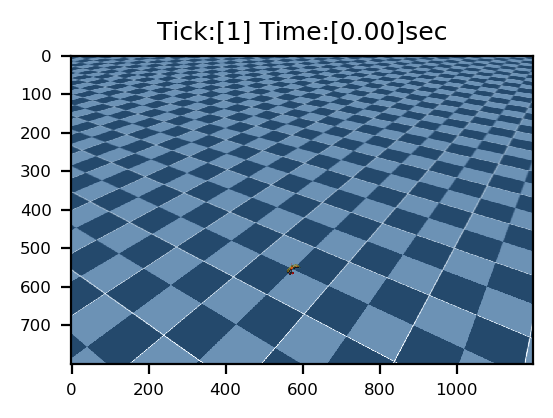

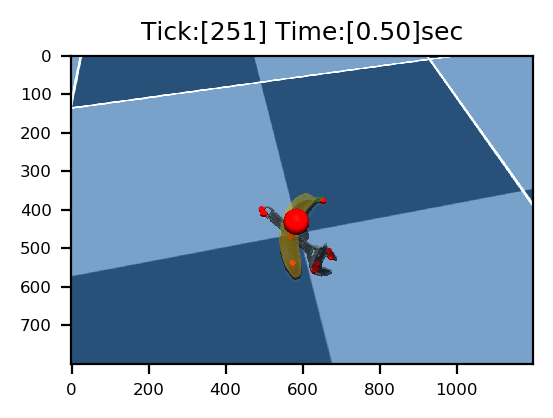

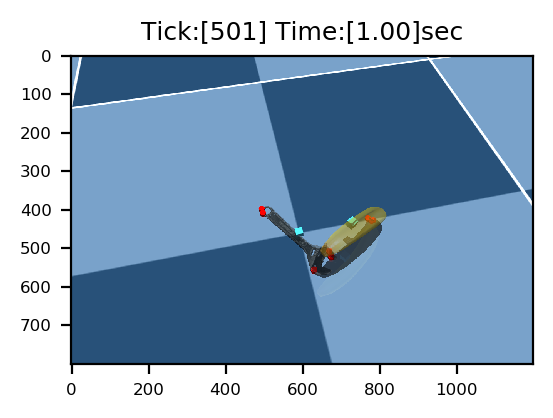

Pressed ESC
Quitting.


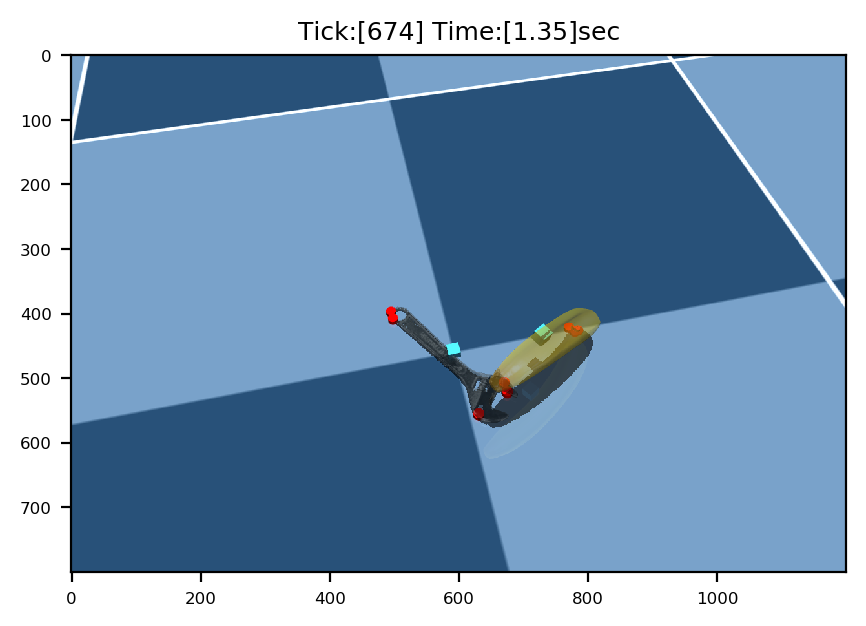

Done.


In [4]:
# Viewer
env.init_viewer(viewer_title='YCB dataset scene',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=124.08,distance=4.00,elevation=-33,lookat=[0.1,0.05,0.86],
                  VIS_TRANSPARENT=True,VIS_CONTACTPOINT=True,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.2,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,1.0])

# Loop
env.reset()
while (env.get_sim_time() < 100.0) and env.is_viewer_alive():
    env.step()
    env.render()
    # Plot
    if env.loop_every(HZ=2):    
        scene_img = env.grab_image()
        plt.figure(figsize=(3,2)); plt.imshow(scene_img)
        plt.title("Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()),fontsize=9)
        plt.show()# Plot an image
plt.figure(figsize=(5,4)); plt.imshow(scene_img)
plt.title("Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()),fontsize=9)
plt.show()
# Close viewer
env.close_viewer()
print ("Done.")